In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageFilter
import numpy as np
import scipy.signal as ss
from scipy.special import ive
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage.filters as filters
%matplotlib inline

In [2]:

class VectorSobel2D(nn.Module):
    def __init__(self, scale=1.0):
        super().__init__()
        self.scale = scale

        # Has some interesting effects (I believe this is the cross Laplacian)
        # array([[  1,   4,   5,   0,  -5,  -4,  -1],
        #        [  4,  16,  20,   0, -20, -16,  -4],
        #        [  5,  20,  25,   0, -25, -20,  -5],
        #        [  0,   0,   0,   0,   0,   0,   0],
        #        [ -5, -20, -25,   0,  25,  20,   5],
        #        [ -4, -16, -20,   0,  20,  16,   4],
        #        [ -1,  -4,  -5,   0,   5,   4,   1]])

        # L = np.array([[1,4,6,4,1]]).T@np.array([[1,4,6,4,1]]).astype(np.float32)
        # L = ive(np.arange(-7,8), self.scale).reshape(1,-1)
        # L = L.T@L
        # print(L)
        # Gx = torch.from_numpy(ss.convolve2d(L, np.array([[1,0,-1]]), 'same')).float()
        # Gy = Gx.clone().T

        Gx = torch.FloatTensor([[1,0,-1],[2,0,-2],[1,0,-1]])
        Gy = Gx.clone().T

        G = torch.stack((Gx, Gy), 0).unsqueeze(1)
        self.filter =nn.Conv2d(1, 2, kernel_size=Gx.shape, stride=1, padding=1, bias=False)
        self.filter.weight = nn.Parameter(G, requires_grad=False)
    
    def forward(self, x):
        y = self.filter(x)*self.scale
        return y

In [3]:
class ScanConversion2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.sobel = VectorSobel2D(16)
        self.thresh = nn.Threshold(1.5, 0)
        self.nms = nn.MaxPool2d(3, 1, padding=1)

        Sx = torch.tensor([[[[1,-1]]]], dtype=torch.float32)
        Sy = Sx.clone().permute(0,1,3,2)
        self.sb_x = nn.Conv2d(1, 1, kernel_size=(1,2), bias=False)
        self.sb_y = nn.Conv2d(1, 1, kernel_size=(2,1), bias=False)
        self.sb_x.weight = nn.Parameter(Sx, requires_grad=False)
        self.sb_y.weight = nn.Parameter(Sy, requires_grad=False)
    
    def forward(self, x):
        y = self.sobel(x)
        y0 = self.sb_x(torch.sign(y[:,0]).unsqueeze(1))[...,:-1,:]
        # y0 = self.thresh(y0)
        y1 = self.sb_y(torch.sign(y[:,1]).unsqueeze(1))[...,:-1]
        # y1 = self.thresh(y1)
        return y, y0, y1

In [4]:
scan_conv = ScanConversion2D()
img_ = Image.open('001_frame023226-o.png')
wi, he = img_.size
padding = 200

# img = Image.new(img_.mode, (wi+2*padding, he+2*padding), (0,0,0))
# img.paste(img_, (padding, padding))

img = img_.filter(ImageFilter.MedianFilter(size=3))
transform = transforms.Compose([
    transforms.Grayscale(),
    # transforms.GaussianBlur(5, sigma=4),
    transforms.ToTensor()
])
x = transform(img)
x.unsqueeze_(0)
y, bx, by= scan_conv(x)

img_cv = np.array(img)
scan = (bx+by)[0].permute(1,2,0).numpy()
# scan_arr = (scan+np.min(scan))/(np.max(scan)-np.min(scan))*255
scan_arr = (np.sign(scan)+1)*255/2
scan_arr = scan_arr.astype(np.uint8).squeeze()


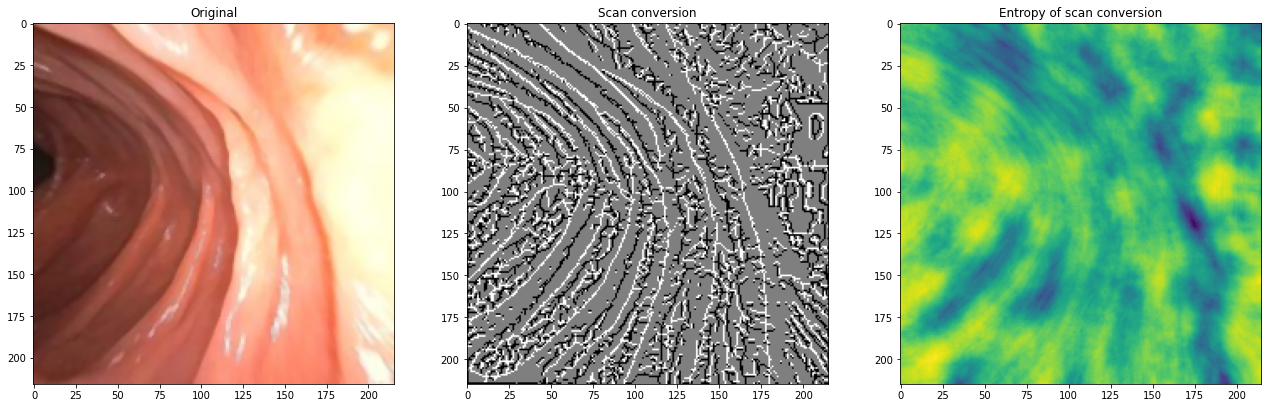

In [5]:
from skimage.filters.rank import entropy
from skimage.morphology import disk

ent_img = entropy(scan_arr, disk(11))
plt.subplots(1,3,figsize=(22,8))
plt.subplot(131)
plt.title('Original')
plt.imshow(img_cv)
plt.subplot(132)
plt.title('Scan conversion')
plt.imshow(scan_arr, cmap='gray')
plt.subplot(133)
plt.title('Entropy of scan conversion')
plt.imshow(ent_img)

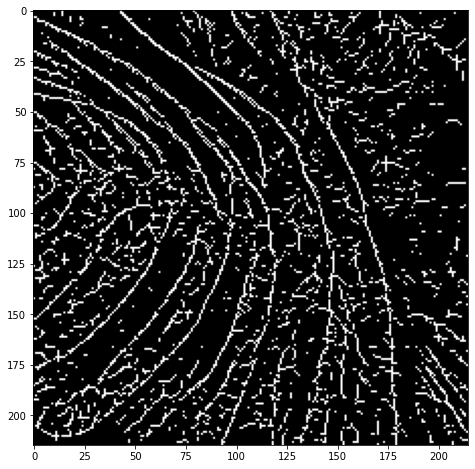

In [6]:
plt.figure(figsize=(10,8))
scan_max = np.sign(np.maximum(scan, 1)-1)
plt.imshow(scan_max, cmap='gray')

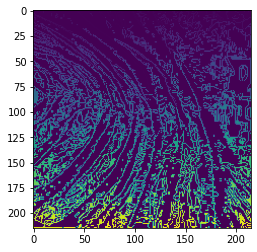

In [7]:
from skimage import measure
labels, nlabel = measure.label(scan_arr, background=1, connectivity=2, return_num=True)
plt.imshow(labels)

5
1.0


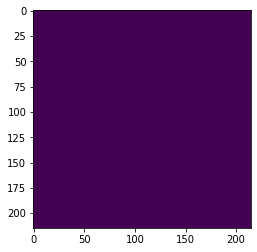

In [8]:
counts = np.zeros(nlabel)
for i in range(nlabel):
    counts[i] = np.count_nonzero(labels==i)
print(np.argmax(counts[2:]))
print(counts[368])
plt.imshow(labels==0)

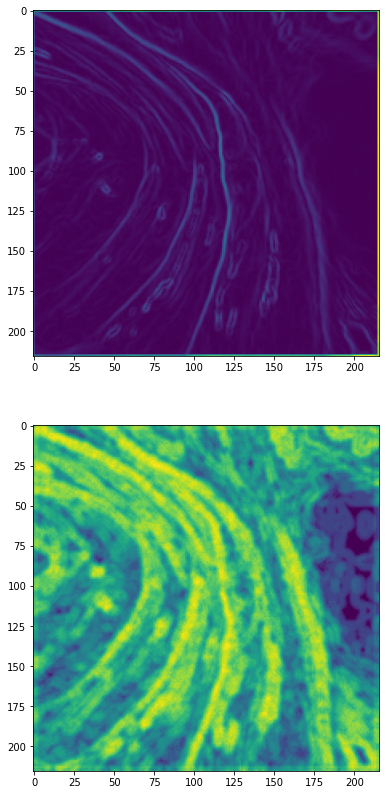

In [9]:
%matplotlib inline
from skimage.util import img_as_ubyte
y_flat = (torch.sqrt((y**2).sum(1))).numpy()
y_flat -= y_flat.min()
y_flat /= y_flat.max()
ent_deriv = entropy(img_as_ubyte(y_flat[0]), disk(3))
plt.subplots(2,1,figsize=(8, 14))
plt.subplot(211)
plt.imshow(y_flat[0])
plt.subplot(212)
plt.imshow(ent_deriv)

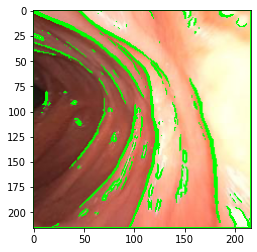

In [10]:
from skimage import filters

thresh = filters.threshold_otsu(y_flat[0][1:-1,1:-1])
binary = y_flat[0]>thresh
green = Image.new("RGB", (img_.width, img_.height), (0, 255, 0))
im_deriv = Image.composite(green, img_, Image.fromarray(binary))
plt.imshow(im_deriv)

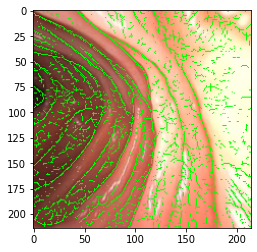

In [11]:
scan_max_im = Image.fromarray(scan_max.squeeze()>0)
green = Image.new("RGB", (img_.width-1, img_.height-1), (0, 255, 0))
im_deriv = Image.composite(green, img_.crop((1, 1, img_.width-1, img_.height-1)), scan_max_im)
plt.imshow(im_deriv)

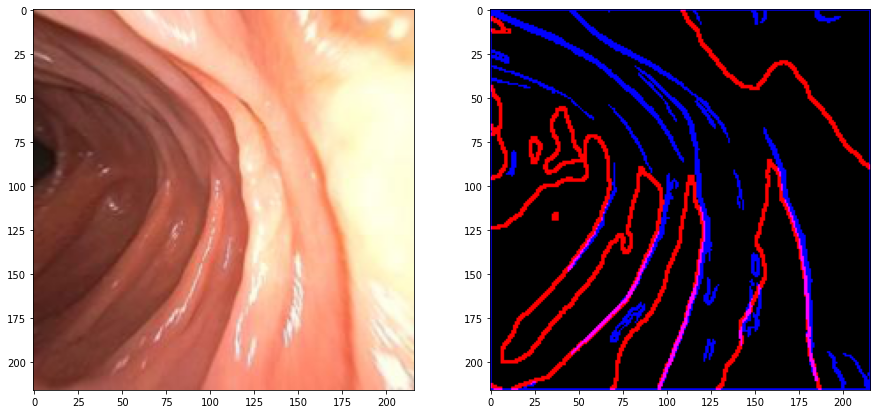

In [12]:
seg = Image.open('001_frame023226.png')
seg_arr = np.array(seg)
seg_mask = seg_arr[:,:,0]==0
seg_sobel = filters.sobel(seg_mask)

analysis = cv2.connectedComponentsWithStats(binary.astype(np.uint8), 8, cv2.CV_32S)
(totalLabels, label_ids, values, centroid) = analysis
output = np.zeros(binary.shape, dtype='uint8')

for i in range(1, totalLabels):
    area = values[i, cv2.CC_STAT_AREA]
    if area>40:
        comp_mask = (label_ids==i).astype('uint8')*255
        output = cv2.bitwise_or(output, comp_mask)

combined = np.stack((np.sign(seg_sobel).astype('uint8')*255, np.zeros_like(output), output), 2)

plt.subplots(1,2,figsize=(15,8))
plt.subplot(121)
plt.imshow(img_)
plt.subplot(122)
plt.imshow(combined)

# nearest neighbor with signed distance function on depth map?

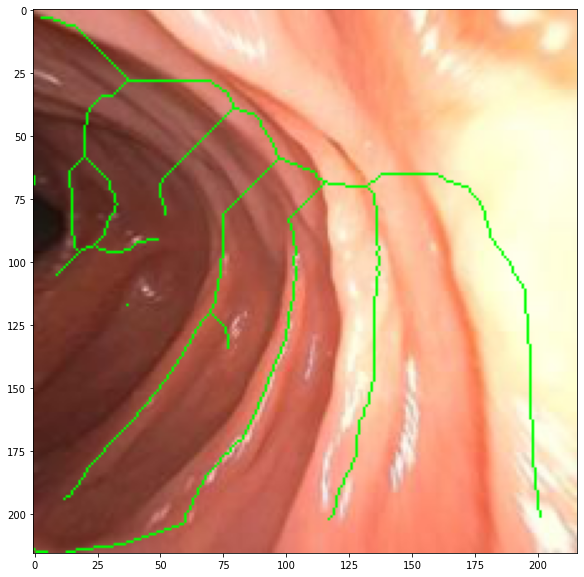

In [13]:
from skimage import morphology

skeleton = morphology.skeletonize(seg_mask, method='lee')
plt.figure(figsize=(10,10))
plt.imshow(Image.composite(Image.new("RGB", (img_.width, img_.height), (0,255,0)), img_, Image.fromarray(skeleton)))
# plt.imshow(skeleton)

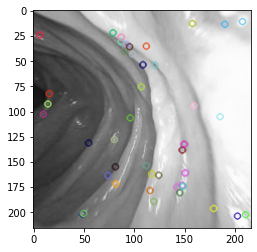

In [19]:
img_cv = cv2.imread('001_frame023226-o.png')

gray = cv2.cvtColor(img_cv,cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)
img = cv2.drawKeypoints(gray,kp,img_cv)
plt.imshow(img)